# Using SpecPolFlow: Example $\xi^1$ CMa (HD 46328)

<img src="diagram3.png" align: center width="1000px">

In the below code, we will walk through how to use [SpecPolFlow](https://github.com/folsomcp/specpolFlow) (with the use of [LSDpy](https://github.com/folsomcp/LSDpy)) with the spectra and polarization data of the magnetic B star $\xi^1$ CMa (HD 46328) ([Erba et al. 2021](https://doi.org/10.1093/mnras/stab1454)), (ESPaDOnS). The code has the following structure:
1. Star Selection
2. Creating the LSD Line Mask
3. Cleaning Line Mask
4. Creating LSD Profile
5. Extracting $B_{\text{z}}$

For additional information on the uses and outputs of either code, please consult their respective GitHubs linked above.

# 1. Star Selection
1. Collect .s file. For this example, we provide the file (hd46328_test_1.s)(ObsId: 2378216p). If you do not have a .s file for your data...TKTKTK
2. Collect important stellar parameters ($T_{\text{eff}}$, log $_g$ , $v\sin i$, observation specific radial velocities). These are provided below: 
    * $T_{\text{eff}} = 27000$ K
    * $\log g = 3.5$ (cgs)
    * $v\sin i  = 15$ km $\text{s}^{-1}$
    * $\text{RV} = 12$ km $\text{s}^{-1}$
3. Next we will need to obtain a list of atomic and molecular transition parameters for $\xi^1$ CMa from The Vienna Atomic Line Database ([Ryabchikova et al. 2015](https://ui.adsabs.harvard.edu/abs/2015PhyS...90e4005R/abstract)). To retrieve a VALD long list, one can go to "Extract Stellar" on the [VALD website](http://vald.astro.uu.se/).  Note that you need to register an email to access the site. The following input was used to obtain the example long list:
    * Starting wavelength: 3700 $\text{\AA}$
    * Ending wavelength: 9000 $\text{\AA}$
    * Detection threshold: 0.01 (line depths shallower than this threshold are not included)
    * Microturbulence: 2 km $\text{s}^{-1}$
    * $T_{\text{eff}} = 27000$ K
    * $\log g = 3.5$ (cgs)
    * Chemical Composition: 0.0 [Fe/H] (Solar)
    * Long format
    * Linelist configuration: Default

    The long list for this star is provided (LongList_T27000G35.dat).

In [6]:

#remove these once they're published
!git clone https://github.com/folsomcp/specpolFlow
!git clone https://github.com/folsomcp/LSDpy

Cloning into 'specpolFlow'...
Cloning into 'LSDpy'...


# 2. Importing Necessary Packages

READY TO START (TKTKTK)

In [9]:
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.constants as const
import specpolFlow as pol
import LSDpy

# 3. Creating LSD Line Mask

To convert the VALD long list into a mask, one needs to call the `make_mask` function using the .dat long list. The user will need to specify the location and name of the output file, `depthCutoff`, and `atomsOnly` (`atomsOnly` = True excludes H lines). This will create a .mask file.

In [10]:

file_name = 'specpolFlow_tutorialfiles/LongList_T27000G35.dat'
file_output = 'specpolFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask'
mask_file = pol.makeMask.make_mask(file_name, file_output, depthCutoff = 0.02, atomsOnly = True)

missing Lande factors for 160 lines (skipped) from:
['He 2', 'O 2']
skipped all lines for species:
['H 1']
Masks made!


# 4. Cleaning Line Mask 
Next, we remove sections in the mask that we do not want affecting the LSD profile. TKTKTK. These include regions 100 km $\text{s}^{-1}$ (specific to this example) around the Balmer series and Balmer gap, around the H-jump, and in areas of telluric contamination.

First the `default_exclude_regions` function takes in the velocity range that you want to exclude and outputs a python dictionary with two elements, WLStart and WLFinish, both of which are arrays.

Then the `clean_model_mask` removes the lines within regions specified by the `default_exclude_regions` output. It takes in the path of the input and output line masks, and the dictionary with the excluded regions. It will then output the new line mask as a .mask file at the specified path. The user supplies the line mask created in the previous step and the function outputs the cleaned outputs with user-specified parameters. The new line mask will be a .mask file at the specified path.




In [13]:
#inputs
#user manual for telleric regions
velrange = 100*u.km/u.s # units are in km/s
data = pol.cleanmask.default_exclude_regions(velrange)
data

{'WLStart': <Quantity [587.5       , 627.5       , 684.        , 717.        ,
            757.        , 790.        , 809.        , 656.08108188,
            485.97784115, 410.03318202, 396.87757172, 360.12008307]>,
 'WLFinish': <Quantity [592.        , 632.5       , 705.3       , 735.        ,
            771.        , 795.        , 990.        , 656.51891812,
            486.30215885, 410.30681798, 397.14242828, 392.13075713]>}

In [14]:
# visualization of excluded regions
pd.DataFrame(data)

,WLStart,WLFinish
0,587.500000,592.000000
1,627.500000,632.500000
2,684.000000,705.300000
3,717.000000,735.000000
4,757.000000,771.000000
5,790.000000,795.000000
6,809.000000,990.000000
7,656.081082,656.518918
8,485.977841,486.302159
9,410.033182,410.306818


In [15]:
# run cleanmask fuction
pol.cleanmask.clean_model_mask('specpolFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask', 'specpolFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask',data)

Masks cleaned!


# 5. Create LSD Profile
Least-Squares Deconvolution (LSD) is a cross-correlation technique for computing the weighted average of selected spectral lines ([Donati et al. 1992](https://ui.adsabs.harvard.edu/abs/1997MNRAS.291..658D/abstract)). From [LSDpy](https://github.com/folsomcp/LSDpy), we use the default conditions:
* normDepth = 0.2 — normalized line depth
* normLande = 1.2 — normalized effective Lande factor
* normWave = 500.0 — normalized wavelength
* removeContPol = 1 — flag for whether the continuum polarization is subtracted from the LSD profile (0 = no, 1 = yes)
* trimMask = 0 — flag for whether very closely spaced lines should be removed from the line mask (0 = no, 1 = yes)
* sigmaClipIter = 0 — number of iterations for sigma clipping, rejecting possible pad pixels based on the fit to Stokes I
* sigmaClip = 500 — if sigma cliping, reject pixels where the observation differs from the model by more than this number of sigma
* interpMode = 1 — mode for interpolating the model on to the observation during LSD (0 = nearest neighbor, 1 = linear interpolation)

The range of the LSD profile is determined by the $v\sin i$ of the star; for this star we use $v\sin i = 15$. To capture the entire line profile, the range of the LSD profile is set to be 100 km $s^{-1}$ for this star. Additionally, the pixel size should be set relative to the resolution of the original data; for ESPaDOnS data, one should not go below $2.6$ km/s per pixel. In a case where the line profile is very broad, it may be advantageous to use larger pixels but make sure the profile has enough data. For our example, we use the ESPaDOnS lower threshold of $2.6$ km $s^{-1}$ per pixel.

When calling main, specify the file (.s file) and mask (.mask file). In the below code, we also input a name and location of outfile (.lsd) but you can choose to display this information without an outfile by calling the variable associated with `lsdpy.main`, which is `lsdoutput` in this example. Outputs here include average observed velocity spacing, number of data points, reduced $\chi^2$ for Stokes V, Stokes I, and N1. For all outputs from this function and additional information on the utilities of the LSD class, see [LSDpy](https://github.com/folsomcp/LSDpy).

In [16]:
vsini = 15
vradCorrected = 0 *u.km/u.s #?

mask = 'specpolFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'

file = 'specpolFlow_tutorialfiles/hd46328_test_1.s'
outfile = 'specpolFlow_tutorialfiles/test_output/hd46328_test_1.lsd'


lsdoutput = LSDpy.lsdpy.main(observation = file, mask = mask, outName = outfile, 
           velStart =- 100.0, velEnd = 100.0, velPixel = 2.6, 
           normDepth = 0.2, normLande = 1.2, normWave = 500.0,
           removeContPol = 1, trimMask = 0, sigmaClipIter = 0, sigmaClip = 500, 
           interpMode = 1, fSaveModelS = 0, outModelName = '',
           fLSDPlotImg = 0, fSavePlotImg = 0, outPlotImgName = '')

FileNotFoundError: [Errno 2] No such file or directory: 'hd46328_test_1.s'

(<Figure size 720x720 with 3 Axes>,
 array([<AxesSubplot:ylabel='V'>, <AxesSubplot:ylabel='N1'>,
        <AxesSubplot:xlabel='Velocity (km/s)', ylabel='I'>], dtype=object))

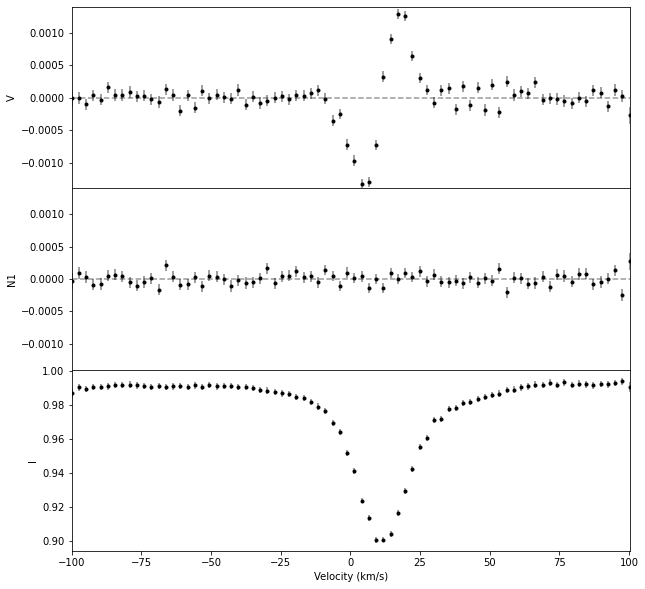

In [17]:
lsd = pol.iolsd.read_lsd(outfile)
lsd.plot()

# 6. Calculate $B_z$ from LSD Profile

To calculate Bz we will be using the `calc_Bz` function which takes in the following:
* lsd - the LSD profile to be used
* cog - the center of gravity. This can either be set manually or calculated from one of the built in functions below.
    * I (from Stokes I)
    * IV (from Stokes I times V)
    * V (from Stokes V)
    * min (minimum of profile)
* velrange - the total range over which will be considered in the Bz calculation. This includes the line itself as well as a little extra on either side
* plot - a flag that determines if an output plot will be automatically generated
* bzwidth - the range over which the Bz will be calculated. This show just include the line itself. If given a single number it will center the range on the cog value.

In the first example we are manually setting the velocity range and Bz width, however it is often useful to set the velocity range to a little larger than the vsini shifted to be centered on the cog value. So for this example velrange could be `velrange=[12-1.5*vsini,12+1.5*vsini]` and bzwidth could be `bzwidth=vsini`. 

In the second example the cog value is being set automatically using the I method. 

The function will then output a dictionary with the following outputs:
* Ic: continuum value used for normalization
* Cog: the center of gravity value
* Bzwidth min (km $s^{-1}$): Lower bound of the Bz width
* Bzwidth max (km $s^{-1}$): Upper bound of Bz width
* V bz (G): Bz calculated from Stokes V profile
* V bz sig (G): standard deviation
* V FAP: false alarm probability [FAP (Donati et al. 1997)](https://ui.adsabs.harvard.edu/abs/1997MNRAS.291..658D/abstract). Definite detection (DD) is defined as having a FAP $< 10^{-5}$. A non-detection (ND) is defined as having a FAP $> 10^{-3}$. FAPs between $10^{-5}$ and $10^{-3}$ are defined as a marginal detection (MD).
* Null calculations - N1 and N2 are two different methods for null profile calculations; N1 is most commonly used.
    * N1 bz (G): Bz calculated from the Null 1 profile
    * N1 bz sig (G): standard deviation
    * N1 FAP: false alarm probability of Null 1 Bz measurement
    * N2 bz (G): Bz calculated from the Null 2 profile
    * N2 bz sig (G): standard deviation
    * N2 FAP: false alarm probability of Null 2 Bz measurement
    
To see additional capabilities of the Bz function, see [SpecPolFlow](https://github.com/folsomcp/specpolFlow) or for a more detailed tutorial, see the [Bz tutorial](https://github.com/folsomcp/specpolFlow/blob/main/tutorials/CalculateBz.ipynb).

using AUTO method for the normalization
  using the median of the continuum outside of the line


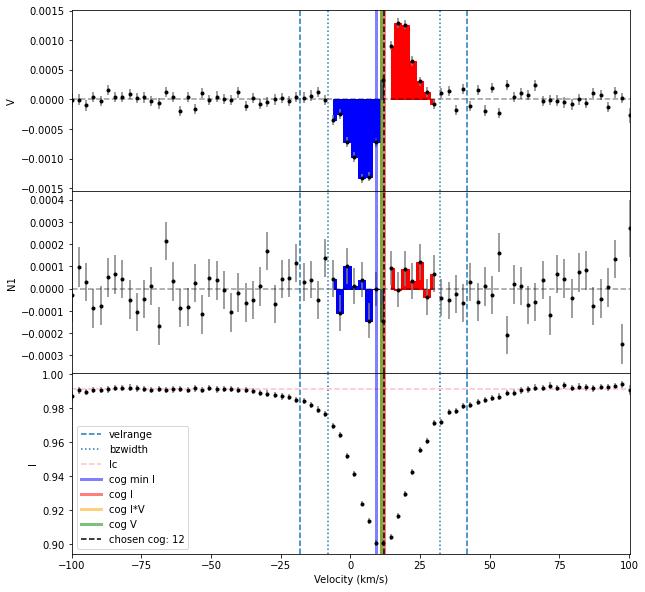

In [18]:
#Bz calculation using manual cog selection
lsdpath = 'specpolFlow_tutorialfiles/test_output/hd46328_test_1.lsd'
model = 'specpolFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'
star = 'hd46328'

vsini = 20
vrad = 12
velrange = [-18,42]
bzwidth = 20
lsd = pol.iolsd.read_lsd(lsdpath)
Bz, fig = pol.bz.calcBz(lsd = lsd, cog = vrad, velrange = velrange, plot = True, bzwidth = bzwidth)

In [19]:
# TKTKTK
pd.DataFrame([Bz])

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.991048,12,-8,32,-114.107172,5.435434,0.0,-4.670879,5.296219,0.283879,0.0,0.0,0.0


using AUTO method for the normalization
  using the median of the continuum outside of the line


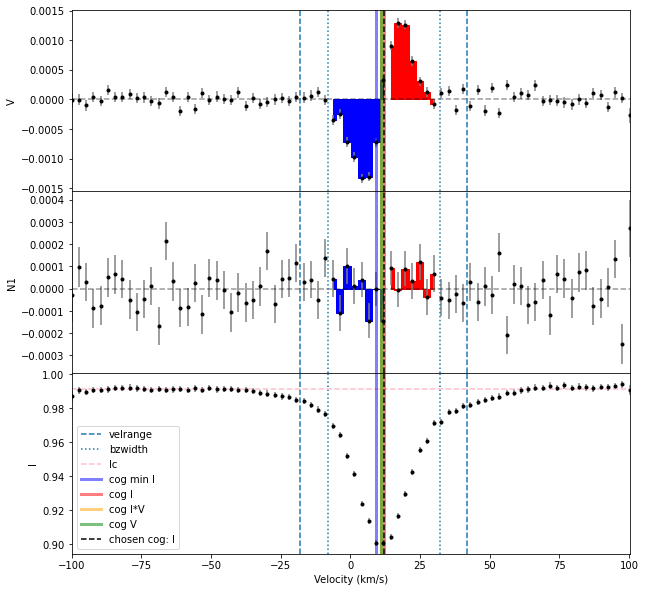

In [20]:
#Bz calculation using automatic cog selection (I)
lsdpath = 'specpolFlow_tutorialfiles/test_output/hd46328_test_1.lsd'
model = 'specpolFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'
star = 'hd46328'

vsini = 20
vrad = 12

lsd = pol.iolsd.read_lsd(lsdpath)
Bz, fig = pol.bz.calcBz(lsd = lsd, cog = 'I', velrange = [(vrad-1.5*vsini),(vrad+1.5*vsini)], plot = True, bzwidth = vsini)

In [21]:
pd.DataFrame([Bz])

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.991048,11.994248,-8.005752,31.994248,-114.101583,5.435377,0.0,-4.671735,5.296171,0.283879,0.0,0.0,0.0
